In [2]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker
import folium

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

## Validating the GTFS stops and CIS data in directions

### Comparing the the frequency of stop sequences of GTFS data in hours 6-25 and CIS data in hours 0-23

There are four heat maps outputted, which indicate the distributions of GTFS data and CIS data of each stop_sequence in hours in different directions.

In [42]:
sql_GTFS_1 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df1 = pandasql.read_sql(sql_GTFS_1, con)

df1 = df1.pivot("hours", "stop_sequence", "schedule")

In [43]:
sql_GTFS_0 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2 = pandasql.read_sql(sql_GTFS_0, con)

df2 = df2.pivot("hours", "stop_sequence", "schedule")

In [44]:
# Chelseas query with stops with no pickup or dropoff are filtered out 
sql_GTFS_0b = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 AND pickup_type <> 1 AND drop_off_type <> 1
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2b = pandasql.read_sql(sql_GTFS_0b, con)

df2b = df2b.pivot("hours", "stop_sequence", "schedule")


In [45]:
sql_cis_1 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691042
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df3 = pandasql.read_sql(sql_cis_1, con)

df3 = df3.pivot("hours", "stop_sequence", "cis_data")

In [46]:
sql_cis_0 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691040
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df4 = pandasql.read_sql(sql_cis_0, con)

df4 = df4.pivot("hours", "stop_sequence", "cis_data")

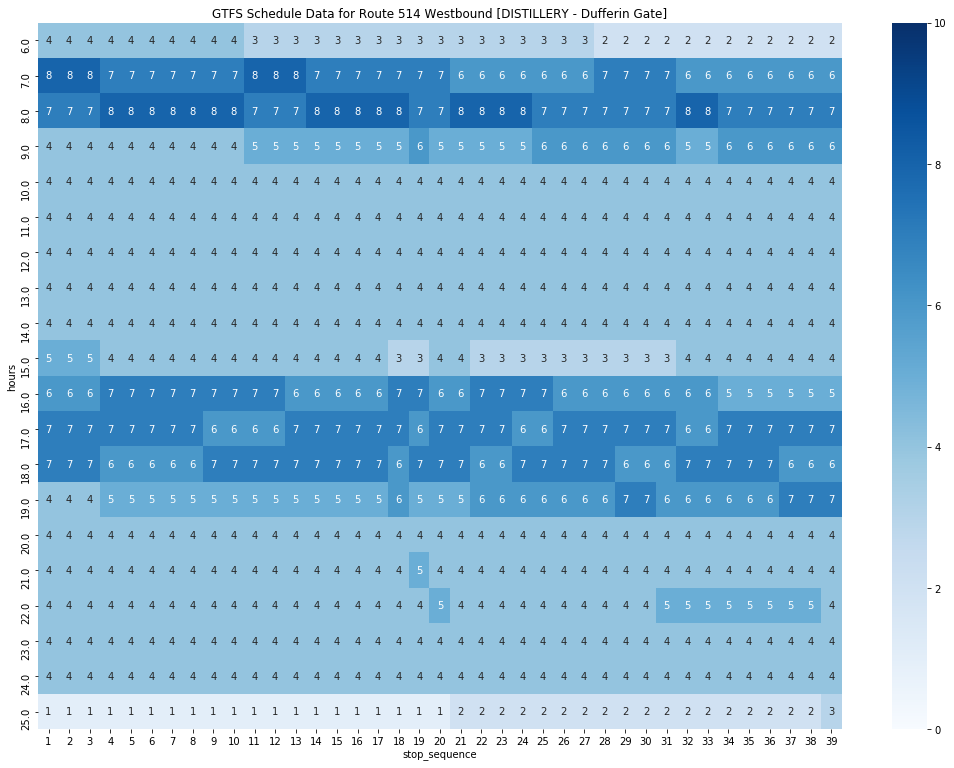

In [47]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('GTFS Schedule Data for Route 514 Westbound [DISTILLERY - Dufferin Gate]')
sns.heatmap(df1, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

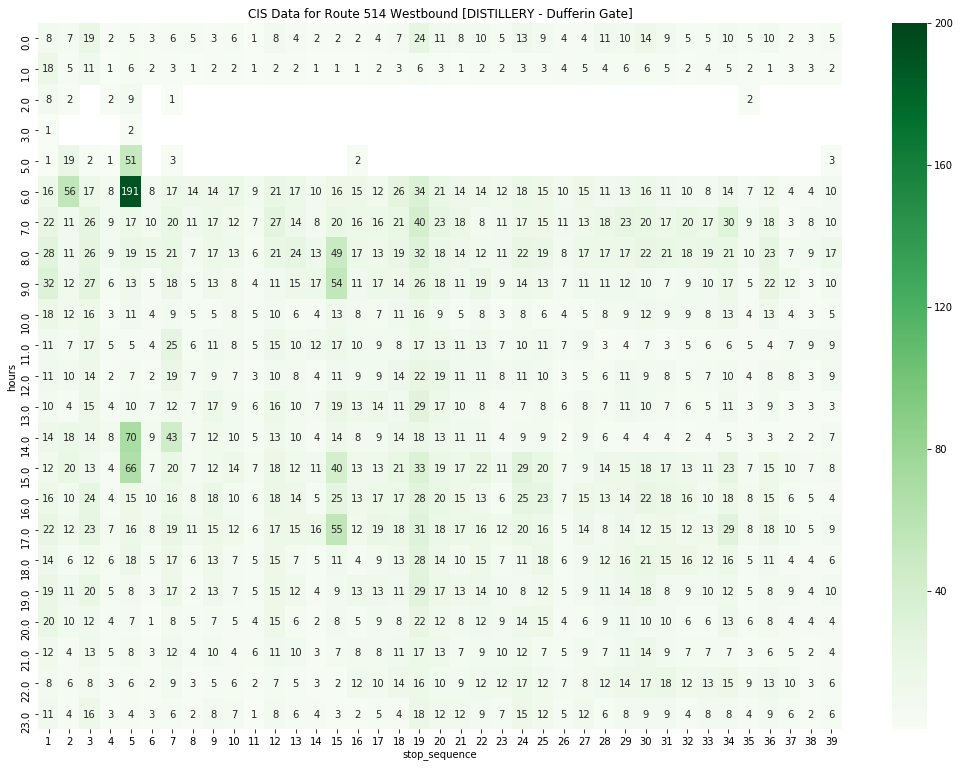

In [48]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS Data for Route 514 Westbound [DISTILLERY - Dufferin Gate]')
sns.heatmap(df3, vmin=1, vmax=200,cmap = 'Greens', annot=True, fmt='g')

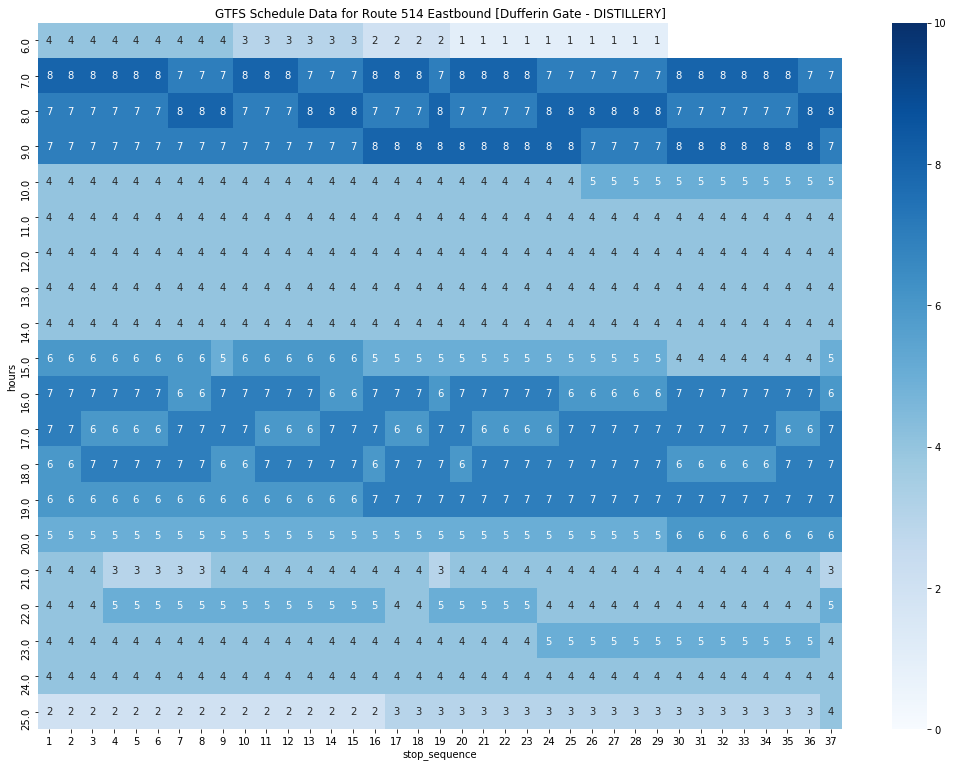

In [49]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('GTFS Schedule Data for Route 514 Eastbound [Dufferin Gate - DISTILLERY]')
sns.heatmap(df2, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

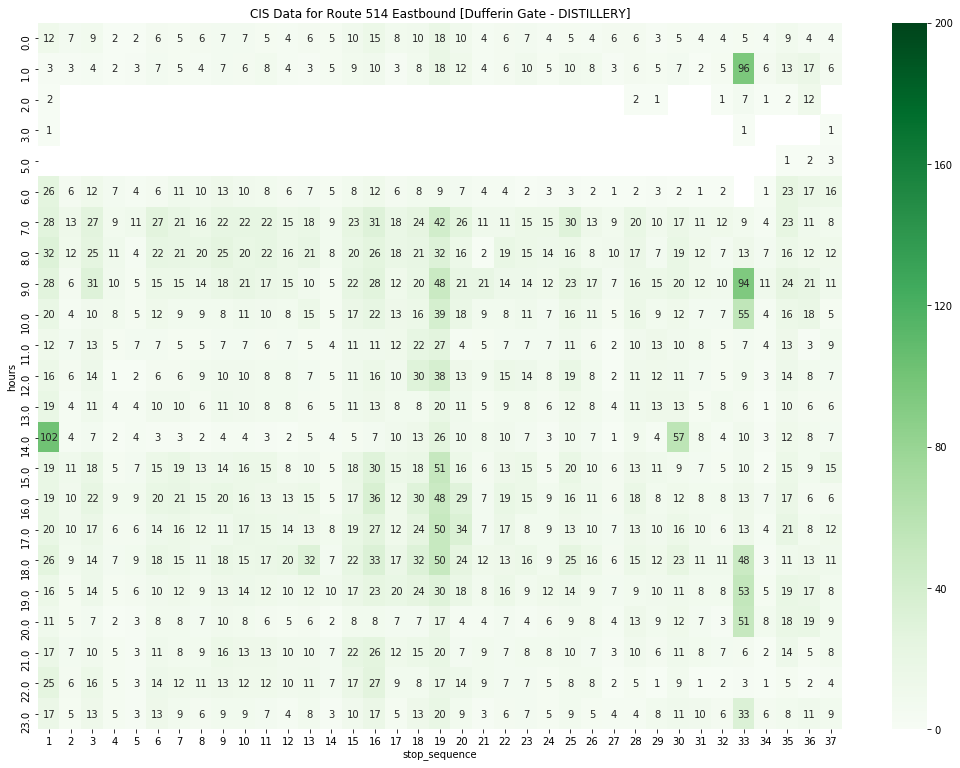

In [50]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS Data for Route 514 Eastbound [Dufferin Gate - DISTILLERY]')
sns.heatmap(df4, vmin=0, vmax=200,cmap = 'Greens', annot=True, fmt='g')

### Validating and Comparing the numbers of GTFS data and CIS data in different stop sequences in a day.

#### The heat maps represent the difference between the count of GTFS schedule service and the count of CIS data with the same stop sequence in hours in the direction of 0 and 1.

In [2]:
# FOR route 514
sql_heatmaps = '''
WITH gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop_514
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
'''

heatmap_df = pandasql.read_sql(sql_heatmaps, con)

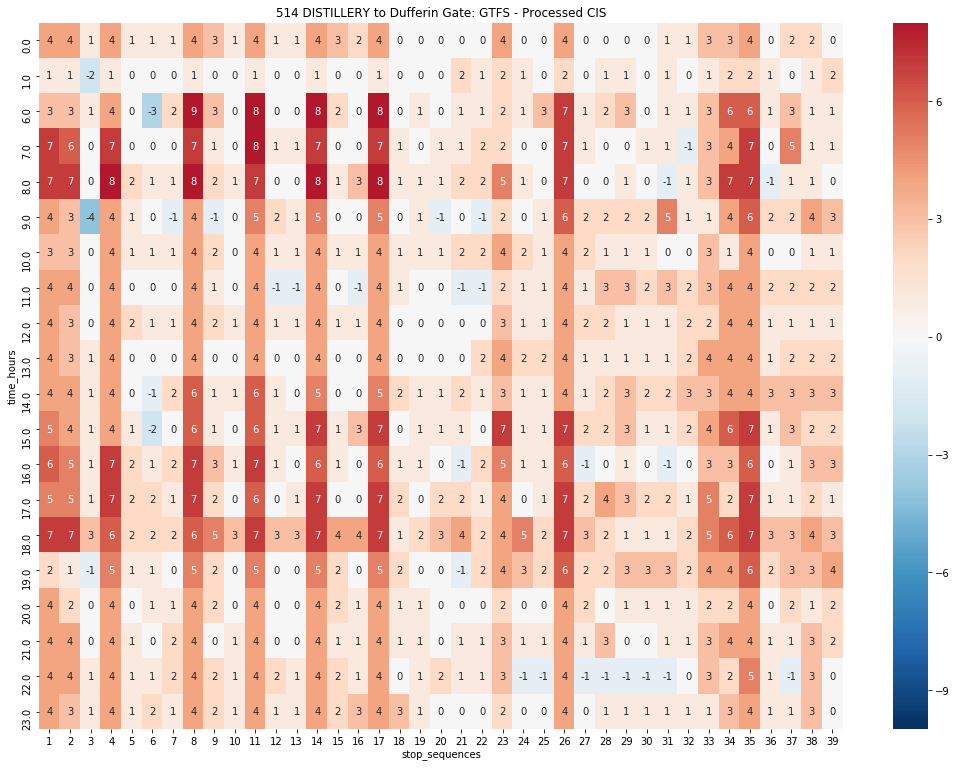

In [3]:
heatmap_df_d1 = heatmap_df[heatmap_df['direction_ids']==1]

heatmap_df_d1 = heatmap_df_d1.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 DISTILLERY to Dufferin Gate: GTFS - Processed CIS')
sns.heatmap(heatmap_df_d1, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

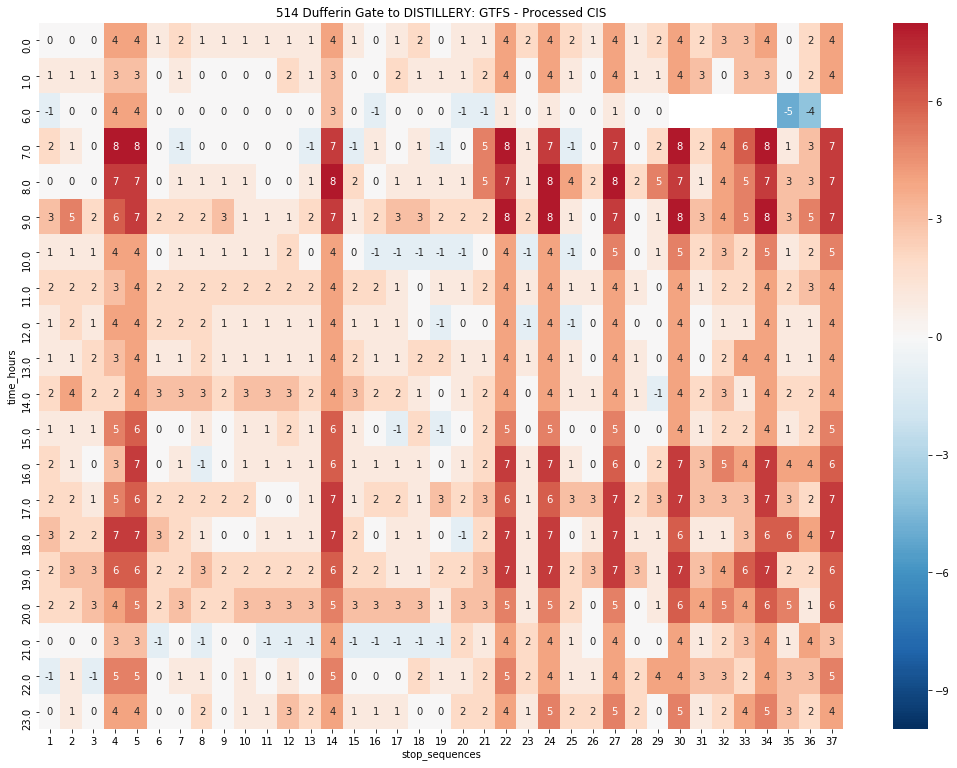

In [4]:
heatmap_df_d0 = heatmap_df[heatmap_df['direction_ids']==0]

heatmap_df_d0 = heatmap_df_d0.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 Dufferin Gate to DISTILLERY: GTFS - Processed CIS')
sns.heatmap(heatmap_df_d0, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

There are some extreme high different values (dark blue cells) at 9 A.M. with stop sequence of 3 and at 6 A.M with stop sequence of 5 when direction_id = 1, and at 6 A.M. with stop sequence of 35 and 36 when direction_id = 0.

In [5]:
# Find the stop IDs and names of the dark blue cells.

sql_stop_sequence = '''
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, stop_name, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042) AND 
((stop_sequence IN (3, 5) AND direction_id = 1) 
OR (stop_sequence IN (35, 36) AND direction_id = 0))
'''

print_table(sql_stop_sequence, con)

stop_id,stop_sequence,stop_name,direction_id,shape_id
7621,5,KING ST EAST AT SACKVILLE ST,1,691042
15354,3,CHERRY ST AT FRONT ST EAST,1,691042
15355,35,CHERRY ST AT FRONT ST EAST,0,691040
15356,36,DISTILLERY LOOP,0,691040


Using the following query, points from the matched stops table were mapped for 6AM where they matched with King St @ Sackville
```sql
SELECT *
 FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1 AND EXTRACT(hour from date_time)  =  6 AND stop_id = 7621
```
We can see that the CIS data showed these were on route 514, despite being on King/Queen past where the 514 turns onto Cherry St. 
![](img/king_sackville_514.PNG)

Now examining some of the stops which are very red above, implying that few CIS records were matched to them. The following query outputs data for stops in the Westbound direction between sequence 8 and 13, stop sequence 11 has few matched CIS records. The larger circles are the stop locations, and the smaller circles are CIS records. The two sets have been colour-coded to match based on stop_sequence number

![](img/king_sherbourne_514.PNG)

We can see that there are multiple scheduled GTFS stops at the same intersection, so few records are ultimately getting matched to 11, because it is in the middle of the intersection. Further inspection of the GTFS data shows that `pickup_type` and `drop_off_type` at this location are 1 which mean:
>**1** - No pickup available  
>**1** - No drop off available

These stops should be filtered out

The stops outputted are closed to or equal to the terminals. The reason of the negative value at these stops at 6 A.M. or 9 A.M. could be that inaccurate GPS locates the streetcars at those stops when streetcars are waiting at the terminals.

In [52]:
sql_stops = '''
SELECT DISTINCT ON(direction_id, stop_sequence , stop_id) stop_id, stop_sequence, stop_name, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
'''

print_table(sql_stops, con)

stop_id,stop_sequence,stop_name,direction_id,shape_id
13268,1,EXHIBITION WEST LOOP,0,691040
6113,2,DUFFERIN GATE LOOP,0,691040
8860,3,DUFFERIN ST AT LIBERTY ST,0,691040
15344,4,DUFFERIN ST AT KING ST WEST,0,691040
13150,5,DUFFERIN AT KING,0,691040
7384,6,KING ST WEST AT FRASER AVE,0,691040
5467,7,KING ST WEST AT ATLANTIC AVE,0,691040
8998,8,KING ST WEST AT SUDBURY ST,0,691040
5422,9,KING ST WEST AT SHAW ST,0,691040
437,10,KING ST WEST AT STRACHAN AVE,0,691040


## Dwell Time Analysis


In [7]:
sql_timediff = '''
SELECT EXTRACT(EPOCH FROM departure_time - arrival_time)/60 AS time_diff
FROM dzou2.match_stop_514
'''
timediff = pandasql.read_sql(sql_timediff, con)

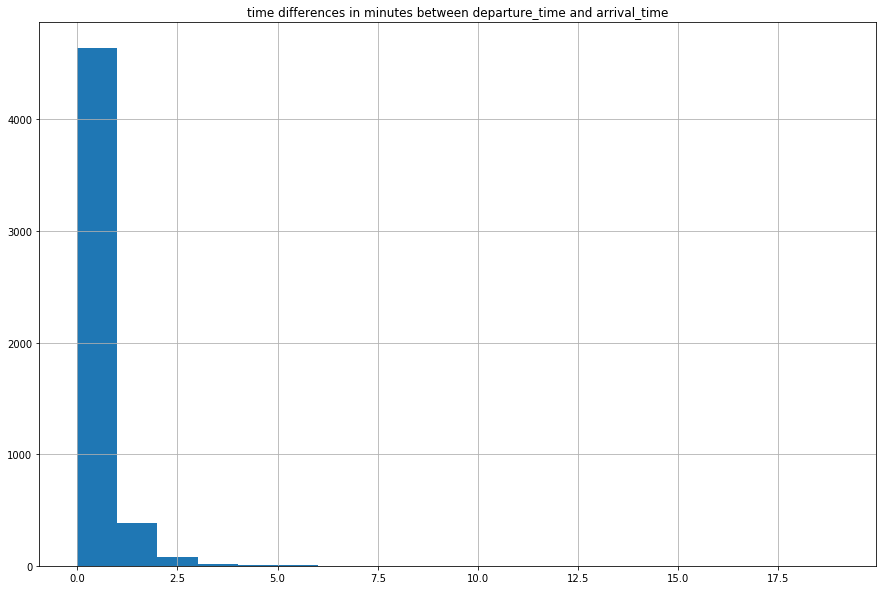

In [8]:
bin_val = np.arange(min(timediff['time_diff']), max(timediff['time_diff']), 1)

timediff.hist(bins=bin_val, figsize=(15,10))
plt.title('time differences in minutes between departure_time and arrival_time')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15) 

There are some values after 5 in the above histogram, but they are not clear since the range of y axis is large (0-4000+), so making another histogram only focuses on the values after 5.

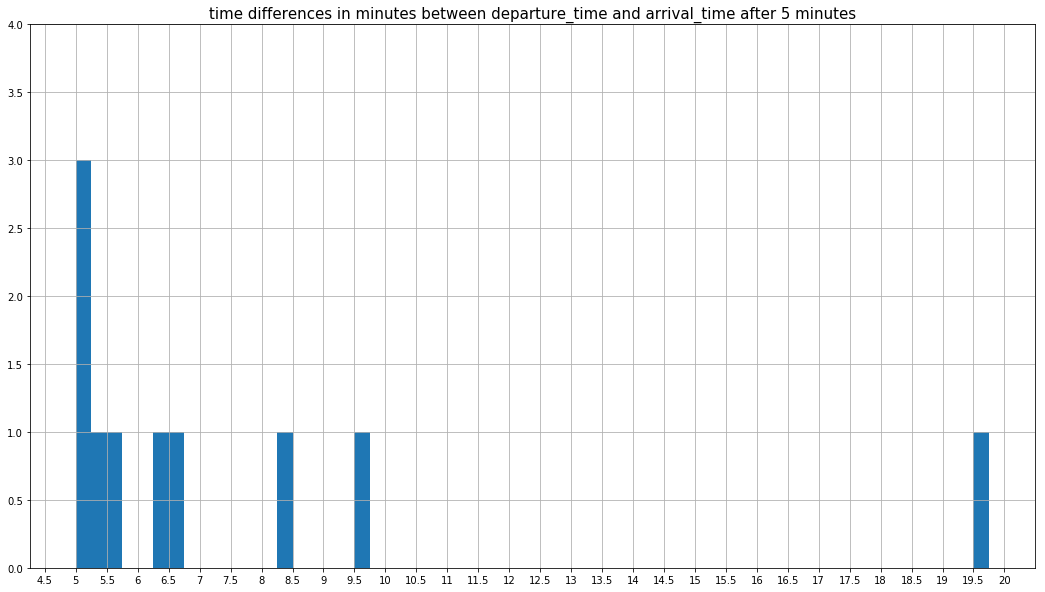

In [10]:
timediff.hist(bins = np.arange(5, 20, 0.25), figsize=(18,10))
plt.title('time differences in minutes between departure_time and arrival_time after 5 minutes')
ax = plt.gca()
ax.set_ylim([0, 4])
f = lambda x,pos: str(x).rstrip('0').rstrip('.')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(f))

plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)    

### The heat maps of Route 504

In [11]:
sql_504_heatmaps = '''
WITH 
gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '504'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop_504
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '504' AND shape_id IN (690863, 690880)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
'''

heatmap_514 = pandasql.read_sql(sql_504_heatmaps, con)

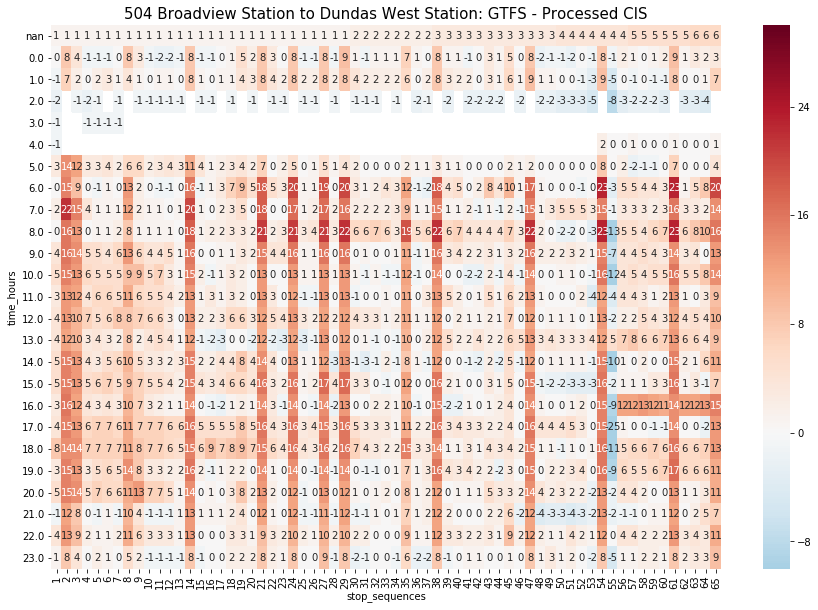

In [12]:
heatmap_514_d1 = heatmap_514[heatmap_514['direction_ids']==1]

heatmap_514_d1 = heatmap_514_d1.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (15,10))
ax = plt.axes()
ax.set_title('504 Broadview Station to Dundas West Station: GTFS - Processed CIS')
sns.heatmap(heatmap_514_d1, vmin=-10, vmax=30, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

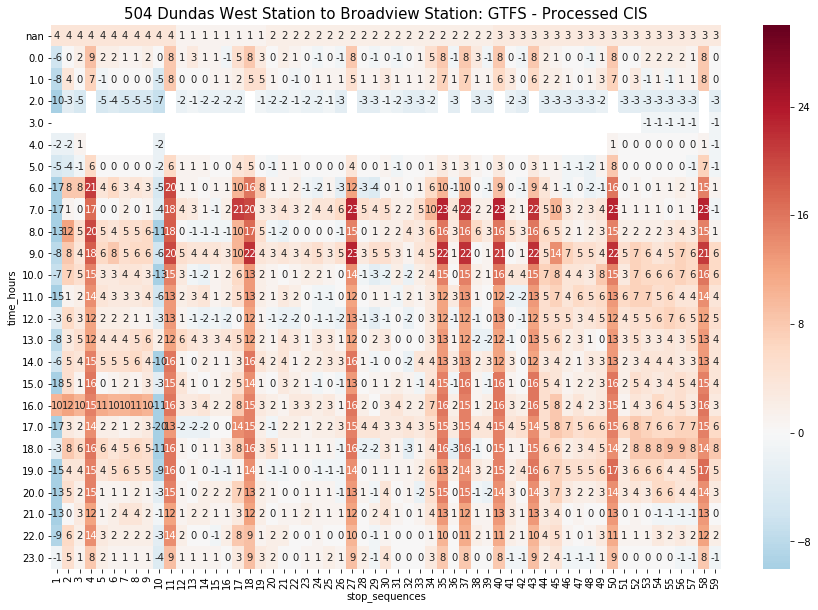

In [13]:
heatmap_514_d0 = heatmap_514[heatmap_514['direction_ids']==0]

heatmap_514_d0 = heatmap_514_d0.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (15,10))
ax = plt.axes()
ax.set_title('504 Dundas West Station to Broadview Station: GTFS - Processed CIS')
sns.heatmap(heatmap_514_d0, vmin=-10, vmax=30, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

### Assign Trip IDs to CIS data 


In [21]:
# create original table in my db 

sql_delete = '''
DELETE FROM crosic.cis_504_10042017_tripids;
'''

sql_insert = '''
INSERT INTO crosic.cis_504_10042017_tripids(arrival_time, departure_time, vehicle, 
stop_id, direction_id, cis_group, orderid)

(SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM dzou2.match_stop_504
ORDER BY vehicle, arrival_time);
'''

#with con:
 #   with con.cursor() as cur:
  #      cur.execute(sql_delete)
   #     cur.execute(sql_insert)


Now we have a table where we can start defining the trip IDs. 

Assign the trip IDs for the CIS data of **route 514 on 10/04/2017** which have more than 10 CIS position records in one trip, and for the CIS data of **route 504 on 10/04/2017** which have at least 10 CIS position records in one trip. There are some CIS data records change their directions abnormally, and some CIS data change their closest stops frequently in the terminal areas because of the unstability of GPS. The abnormal points create short trips as the table shown below, and filtering out the short trips can help to assign the trip IDs to the more reliable CIS data.

In [61]:
sql_find_tripIDs3 = '''
DROP SEQUENCE IF EXISTS tripid_seq;
-- CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_504_10042017_tripids
ORDER BY vehicle, arrival_time
),

open_array AS (
SELECT trip_id, arrival_time, departure_time, unnest(cis_group) AS cis_id, direction_id, vehicle, stop_id
FROM trips
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM open_array
GROUP BY trip_id; 

-- DROP TEMPORARY SEQUENCE tripid_seq;
'''


sql_find_tripIDs4 = '''
DROP TABLE IF EXISTS crosic.cis_504_10042017_tripids2; 
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
INTO crosic.cis_504_10042017_tripids2
FROM crosic.cis_504_10042017_tripids
ORDER BY vehicle, arrival_time;

DROP SEQUENCE tripid_seq;
'''


#with con:
 #   with con.cursor() as cur:
        #cur.execute(sql_find_tripIDs4)



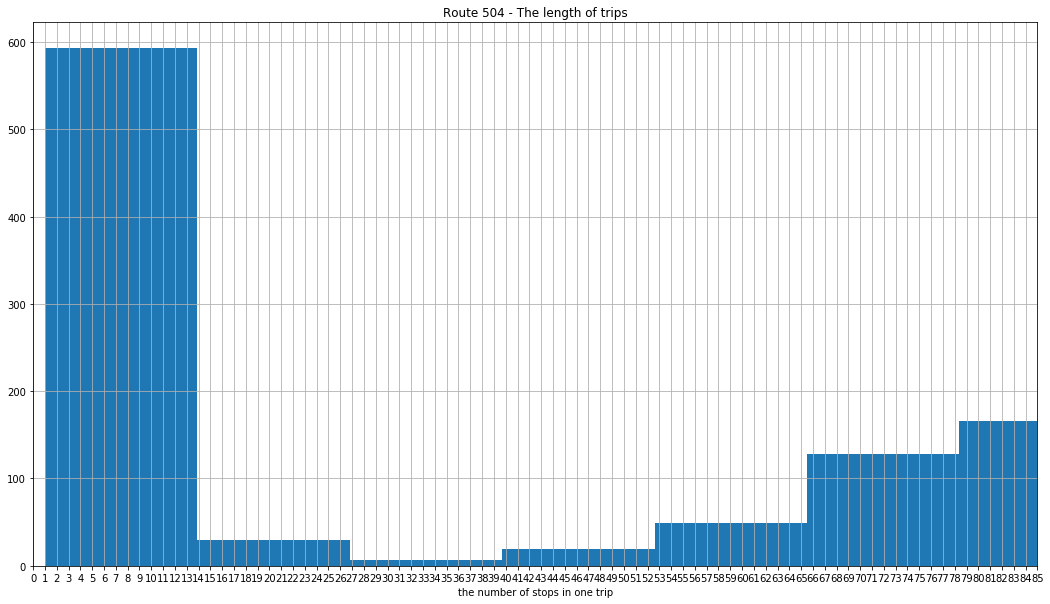

In [35]:
trips_504 = pandasql.read_sql(sql_find_tripIDs3, con)
trips_504.hist(figsize=(18,10))
plt.xlabel('the number of stops in one trip')
plt.title('Route 504 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 85])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

As the table shown, the longest trip has 80+ CIS data records, and the shorter trips have 20+ data records. However, there are multiple trips have 1-9 data records which may be the trips with errors, and there are few trips with has the number of data records between 9 and 20. The fracture seems like the indicator, and the trips with less than 10 data records are too short, so the trips with less than 10 data records will be filtered out.

Upon further investigation, there was a lot of direction changes around the same time near the two subway stations that the streetcar goes to. (Broadview with stopID 13050 and Dundas West with stopID 13209).

Now do the same thing for the 514

In [15]:
sql_delete = '''
DROP TABLE IF EXISTS crosic.cis_514_10042017_tripids_after;
'''

sql_insert = '''
SELECT * INTO crosic.cis_514_10042017_tripids
FROM
(SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM dzou2.match_stop_514
ORDER BY vehicle, arrival_time) AS T;
'''
with con:
    with con.cursor() as cur:
        cur.execute(sql_delete)
        cur.execute(sql_insert)

In [18]:
sql_find_tripIDs3 = '''
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_514_10042017_tripids
ORDER BY vehicle, arrival_time
),

open_array AS (
SELECT trip_id, arrival_time, departure_time, unnest(cis_group) AS cis_id, direction_id, vehicle, stop_id
FROM trips
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM open_array
GROUP BY trip_id;
'''


sql_find_tripIDs4 = '''
DROP TABLE IF EXISTS crosic.cis_514_10042017_tripids2; 
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
INTO crosic.cis_514_10042017_tripids2
FROM crosic.cis_514_10042017_tripids
ORDER BY vehicle, arrival_time;
'''


#with con:
#    with con.cursor() as cur:
       # cur.execute(sql_find_tripIDs4)

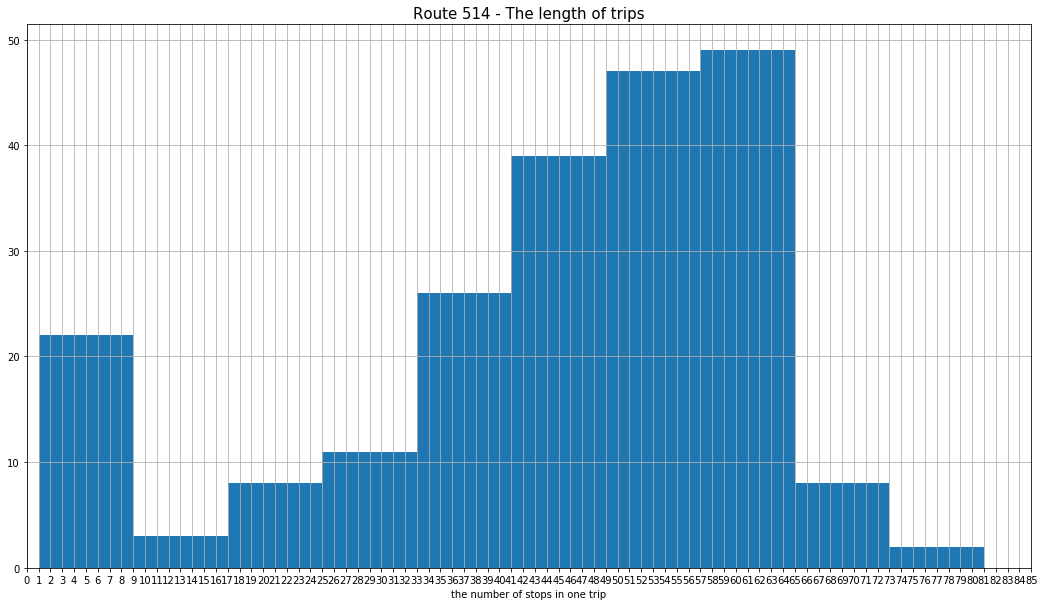

In [19]:
trips_514 = pandasql.read_sql(sql_find_tripIDs3, con)
trips_514.hist(figsize=(18,10))
plt.xlabel('the number of stops in one trip')
plt.title('Route 514 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 85])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

In [32]:
sql_504_shapes = '''
SELECT shape_id, count(*) FROM dzou2.dd_504_stop_pattern
GROUP BY shape_id
ORDER BY count(*)
'''

print_table(sql_504_shapes, con)

shape_id,count
690864,10
690866,11
690882,12
690881,14
690867,50
690873,53
690860,58
690859,59
690863,59
690880,65


The stops that have under 10 stops for route 504 should be examined.

The number of stops of the shortest shape for route 504 is 10, so each trip should have at least 10 data records.

(The reason why not using this method for route 514 is that the number of stops of shortest shape in route 514 is 30, which will filtered out too many trips if the number is the filter indicator; also, the trips of route 514 have the obvious fracture, while the trips of route 504 do not.)

Since it has multiple shapes, and some of the shapes are very short, the number of filter indicator will based on the number of stops of the shortest shapes. 

In [7]:
sql_514_shapes = '''
SELECT shape_id, count(*) FROM crosic.dd_514_stop_pattern
GROUP BY shape_id
ORDER BY count(*)
'''

print_table(sql_514_shapes, con)

shape_id,count
691041,24
691043,27
691040,30
691042,32


There are problems where we have certain trips that are very short (i.e. 1 or 2 stops). In order to fix this problem, we need to gain a better understanding of the data. We will find out where the majority of the trips end (last stop before direction changes) then check to see if these endpoints are consistent with the actual endpoints of the route.

## Exploring the locations where trips end

The shapes of all the streetcar routes in the GTFS data will be examined in order to investigate further into the 504 and the 514 streetcar short turns. 

In [8]:
shapes_sql = """
SELECT DISTINCT shape_id, route_id, trip_headsign
FROM gtfs_raph.trips_20171004 
WHERE route_id = 52485 OR route_id = 52476
ORDER BY route_id;
"""

shapes = pandasql.read_sql(shapes_sql, con)

shapes



,shape_id,route_id,trip_headsign
0,690859,52476,EAST - 504 KING TOWARDS BROADVIEW STATION VIA ...
1,690860,52476,EAST - 504 KING TOWARDS BROADVIEW STATION VIA ...
2,690863,52476,EAST - 504 KING REPLACEMENT BUS TOWARDS BROADVIEW
3,690864,52476,EAST - 504 KING TOWARDS BROADVIEW STATION VIA ...
4,690866,52476,EAST - 504 KING TOWARDS RONCESVALLES AND QUEEN
5,690867,52476,EAST - 504 KING TOWARDS BROADVIEW STATION VIA ...
6,690870,52476,WEST - 504 KING TOWARDS DUNDAS WEST STATION VI...
7,690873,52476,WEST - 504 KING TOWARDS RONCESVALLES AND QUEEN
8,690880,52476,WEST - 504 KING REPLACEMENT BUS TOWARDS DUNDAS...
9,690881,52476,WEST - 504 KING TOWARDS BROADVIEW


### Mapping the GTFS shapes and the locations where the trips end

The hexagons on the maps below represent the locations where the trips ended. The size of the hexagons are scaled by the number of times that a trip ended at that paticular stop. There is a map for every unique GTFS shape (i.e. if there were two shapes where the lines were the same but the route was in a different direction than I would only map one of these two). The GTFS shapes are blue lines on the map. 

In [98]:
# select points from shapes file, add them as polyline to a map
# https://stackoverflow.com/questions/23905822/print-a-line-multiline-in-a-new-layer-over-a-map-using-folium

shape691040_sql_514 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  691040
ORDER BY shape_pt_sequence
"""
shape691040_514 = pandasql.read_sql(shape691040_sql_514, con)

shape691041_sql_514 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  691041
ORDER BY shape_pt_sequence
"""
shape691041_514 = pandasql.read_sql(shape691041_sql_514, con)

shape691043_sql_514 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  691043
ORDER BY shape_pt_sequence
"""
shape691043_514 = pandasql.read_sql(shape691043_sql_514, con)

# 504 routes 

shape690859_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690859
ORDER BY shape_pt_sequence
"""
shape690859_504 = pandasql.read_sql(shape690859_sql_504, con)


shape690860_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690860
ORDER BY shape_pt_sequence
"""
shape690860_504 = pandasql.read_sql(shape690860_sql_504, con)


shape690863_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690863
ORDER BY shape_pt_sequence
"""
shape690863_504 = pandasql.read_sql(shape690863_sql_504, con)

shape690864_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690864
ORDER BY shape_pt_sequence
"""
shape690864_504 = pandasql.read_sql(shape690864_sql_504, con)

shape690866_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690866
ORDER BY shape_pt_sequence
"""
shape690866_504 = pandasql.read_sql(shape690866_sql_504, con)

shape690867_sql_504 = """
SELECT shape_pt_lat, shape_pt_lon
FROM gtfs_raph.shapes
WHERE shape_id =  690867
ORDER BY shape_pt_sequence
"""
shape690867_504 = pandasql.read_sql(shape690867_sql_504, con)



In [99]:
sql_trip_count_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    -- GROUP BY trip_id, stop_id, arrival_time
    ORDER BY trip_id, arrival_time DESC
)

SELECT COUNT(*) AS cnt, stop_id, stop_name, stop_lat, stop_lon -- INTO crosic.count_data_504_20171004
FROM last_stop_trips
GROUP BY stop_id, stop_name, stop_lat, stop_lon 
ORDER BY cnt DESC;
"""

last_stop_514 = pandasql.read_sql(sql_trip_count_514, con)

In [100]:
sql_trip_count_504 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
)

SELECT COUNT(*) AS cnt, stop_id, stop_name, stop_lat, stop_lon
FROM last_stop_trips
GROUP BY stop_id, stop_name, stop_lat, stop_lon 
ORDER BY cnt DESC;
"""

last_stop_504 = pandasql.read_sql(sql_trip_count_504, con)

In [101]:
# map shapes 

# 514
shape_map691040 = folium.Map(location=[43.646750, -79.395476], zoom_start=14)
shape_map691041 = folium.Map(location=[43.646750, -79.395476], zoom_start=14)
shape_map691043 = folium.Map(location=[43.646750, -79.395476], zoom_start=14)

# 504 
shape_map690859 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690860 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690863 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690864 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690866 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)
shape_map690867 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)

maps514 = [shape_map691040, shape_map691041, shape_map691043]
sql_outputs514 = [shape691040_514, shape691041_514, shape691043_514] 

maps504 = [shape_map690859, shape_map690860, shape_map690863, shape_map690864, shape_map690866, shape_map690867]
sql_outputs504 = [shape690859_504, shape690860_504, shape690863_504, shape690864_504, shape690866_504, shape690867_504] 

#maps_dict = {shape_map691040:last_stop_514.itertuples(), shape_map691041:last_stop_514.itertuples(), shape_map691043:last_stop_514.itertuples(), 
#             shape_map690859:last_stop_504.itertuples()}

# make 514 maps
for map in maps514: 
    points = []
    for row in sql_outputs514[maps514.index(map)].itertuples(): 
        points.append([float(row[1]), float(row[2])])


    for row in last_stop_514.itertuples(): 
        popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
        #print(popup_str)
        folium.RegularPolygonMarker([ float(row[4]), float(row[5]) ], 
                            popup=popup_str, 
                           radius = (int(row[1])), 
                           fill_color = '#DC143C', 
                            number_of_sides=6,
                           color = '#DC143C').add_to(map)
        folium.PolyLine(points).add_to(map)


        
# make 504 maps
for map in maps504: 
    points = []
    for row in sql_outputs504[maps504.index(map)].itertuples(): 
        points.append([float(row[1]), float(row[2])])


    for row in last_stop_504.itertuples(): 
        popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
        #print(popup_str)
        folium.RegularPolygonMarker([ float(row[4]), float(row[5]) ], 
                            popup=popup_str, 
                           radius = (int(row[1]/5)), 
                           fill_color = '#DC143C', 
                            number_of_sides=6,
                           color = '#DC143C').add_to(map)
        folium.PolyLine(points).add_to(map)

        


In [102]:
# route 514
shape_map691040

In [103]:
# route 514
#shape_map691041

In [104]:
# route 514
shape_map691043

# this map is the same as the one above, just has a different direction 

The trends in the 514 route are that there is a large number of streetcars changing direction around the Distillery Loop and Dufferin Gate Loop (also called Exhibition West Loop) since those are the endpoints of the route. 

It is strange that there is a count of 69 at the Cherry Street at Front Street East stop. This count is higher than the count at the Distillery Loop, which is one stop away. The stop could possibly be getting mixed up with the Distillery Loop stop, even though is appears to be somewhat far from the loop on the above map. The stop is somewhat close to where the streetcar turns onto King street, and is the last stop before the streetcar turns onto King Street when going Westbound (or first stop after streetcar turns onto Cherry Street from King Street if going Eastbound). There is no such mixup near the Dufferin Loop, even though the streetcar turns onto Dufferin Street from King Street before reaching the Dufferin Gate Loop, so it is not entirely clear why there is a stop with such a high count near this endpoint. 

The stop King Street at Sackville Street has a count of 9, which could be attributed to the fact that there is most likely some sort of loop located there. The map above indicates that there is a route that ends very close to this stop, which most likely explains the high count at that stop. 

There is a count of 6 at the stop King Street West at Blue Jays Way. The stop is not close to either route endpoints and it is not near any intersections that the streetcar turns. However, **the stop is close to the Charlotte Street Loop, ** which is a place where streetcars can use to short-turn (i.e end their route and change direction early). 

We need to investigate the trips that still cannot be explained more clearly, and get the date/timestamps for these trips

In [105]:
# 504 
shape_map690859

In [ ]:
#shape_map690860

In [ ]:
#shape_map690863

In [106]:
shape_map690864

The cell above can explain why there is a count of 34 at the stop titled Broadview Ave at Queen Street East. 

In [107]:
shape_map690866

In [108]:
shape_map690867

The last two route shapes above are due to the loop that goes through the Roncesvalles Carhouse trackage, at Roncesvalles Ave. and the Queensway. 

From the above data, we can see that the stops with the first and third most direction changes are Broadview Station and Broadview Station at Danforth Ave, which are the last/first (depending on direction) two stops on the route. There are two stop_id's tied to Broadview Station in the data. Broadview Station and Broadview Station at Danforth Ave have total counts of 367 and 141 respectively. It is likely that Broadview Station at Danforth Ave is being mistook as the point where the direction of the bus changes, since it is so close to Broadview Station. 

Dundas West Station has two stop_id's and appaears twice in the list. This station is the other final stop on the route, and it has a total count of 311.  

Roncesvalles Ave at Queen St West has the fourth highest count of 98, and it is 9 stops away from Dundas West Station. Additionally, there is a stop called Ronc. at Queen, which has a count of 42 and appears to be the same stop as Roncesvalles Ave at Queen St West. The two stops are very close to eachother.Both stops were on Google Maps, and were identified as actual stops. However, Ronc. at Queen had far less information attatched to it (i.e. there were no bus/streetcar routes attached to it). I did further research and could not find the Ronc. at Queen bus stop on the TTC website under any routes. Either way, there was a total of 140 times where the streetcar changed direction in the area. **The streetcar changed direction here because there is a loop located here. ** The loop goes through the Roncesvalles Carhouse trackage, at Roncesvalles Ave. and the Queensway. The GTFS shapes file contains two shapes that end at the intersection of Roncesvalles Ave and Queen St West, which confirms that the streetcar passes through the loop during some routes. 

The stop titled Broadview Ave at Queen Street East is equivalent to the stops titled Queen Street East at Broadview Ave, and Broadview at Queen which appear in the data. It's count is 34, and after this stop the streetcar turns onto Broadview Avenue. The shapes GTFS file shows that there is a route that starts at Broadview Station and ends and the intersection of Bradview Avenue and Queen Street West. 

Roncesvalles Ave at Boustead Ave South Side is three stops away from Dundas West Station and has a count of 60. Upon further inspection, this stop is not very close to the station and the street car would not be making any sudden turns near here. At this point, there is no clear reason why the streetcar chose to change direction here. Other stops where there is no apparent explaination as to why there is a direction change include Roncesvalles Ave at Marion St North Side (count of  27, 7 stops from Dundas West), Broadview Ave at Wolfrey Ave (count of 16 and 2 stops from Broadview station).

The stop Broadview Avenue at Dundas Street East having a count of 12. There is a slight turn on King street and Ontario street, which could possibly be the cause of the streetcar changing direction after the King Street East at Ontario Street stop. However the shapes GTFS file does not back this hypothesis. 

On the official TTC website, there are stops listed which do not match any of the shapes from the GTFS shapes file. It seems that there is an option for the 504 streetcar to turn onto Gerrard Street, go south to Dundas Street and River Street, and then turn back to Gerrard and Broadview, and end up on Broadview again. However, this route/detour was never taken on the day of October 4, 2017 (the extra stops not maintained in the GTFS shapes file were not in the stop_times_10042017_504_514). Therefore this detour cannot be attributed to any of the 'odd' locations where the routes end.

Source for where the loops are located: https://en.wikipedia.org/wiki/Toronto_streetcar_system_loops


I would like to see if there are certain vehicles that end their stops at irregular places (i.e. maybe their direction change software is broken), and I would like to see if the vehicle is a bus or a streetcar. The following query says how many times a final stop on a trip occurs at a location that is not a location that is justified by the shapes file, the location of loops where the streetcar can turn, or the fact that the stop is close to a stop is jusitifed by loops or the shapes file. 


## Looking at vehicle type and effect on trip endpoints

In [19]:
sql_trip_vehicle_504 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
), 

avl_v AS 
(SELECT DISTINCT(vehicle_number) AS vehicle, vehicle_type FROM ttc.avl) 

SELECT DISTINCT l.vehicle, vehicle_type, COUNT(trip_id) AS cnt -- , stop_lat, stop_lon, vehicle, a.vehicle_type -- INTO crosic.count_data_504_20171004
FROM last_stop_trips l LEFT JOIN avl_v a ON l.vehicle = a.vehicle
WHERE stop_id NOT IN (13050, 4402, 2800, 13209, 14186, 310, 13720, 10325, 3443, 4041, 7898, 9752, 1222)
GROUP BY l.vehicle, vehicle_type -- , l.stop_name
ORDER BY cnt;
"""

last_stop_vehicle_504 = pandasql.read_sql(sql_trip_vehicle_504, con)

last_stop_vehicle_504 

,vehicle,vehicle_type,cnt
0,4086,streetcars,1
1,4096,streetcars,1
2,4141,streetcars,1
3,4193,streetcars,1
4,4202,streetcars,1
5,4212,streetcars,1
6,4229,streetcars,1
7,7578,replacement buses,1
8,7679,replacement buses,1
9,8676,replacement buses,1


The vehicle type or vehicle itself most likely does not contribute to the trips ending at irregular places. 

## A more in depth look at trips that end where they are not supposed to

From the following query, there are 125 out of 1176 trips (10.6% of trips) with stops that end at stops that are not expected stops for trips to end at. 

In [2]:
sql_count_504 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
)

SELECT COUNT(trip_id) AS cnt
FROM last_stop_trips l
ORDER BY cnt;
"""


sql_count_irreg_504 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
)

SELECT COUNT(trip_id) AS cnt
FROM last_stop_trips l
WHERE stop_id NOT IN (13050, 4402, 2800, 13209, 14186, 310, 13720, 10325, 3443, 4041, 7898, 9752, 1222, 13040, 8975, 14837, 14161)
ORDER BY cnt;
"""
last_stop_count_504 = pandasql.read_sql(sql_count_504, con)

last_stop_count_irreg_504 = pandasql.read_sql(sql_count_irreg_504, con)


In [30]:
last_stop_count_504

,cnt
0,1176


In [31]:
last_stop_count_irreg_504

,cnt
0,125


Now find out where the irrgular trips begin and end 

In [58]:
sql_length_irreg = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
),

first_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time ASC
),

len_irreg_trip AS (
SELECT COUNT(*) cnt, l.trip_id, l.stop_name, l.stop_id
FROM last_stop_trips l LEFT OUTER JOIN crosic.cis_504_10042017_tripids2 c ON l.trip_id = c.trip_id
WHERE l.stop_id NOT IN (13050, 4402, 2800, 13209, 14186, 310, 13720, 10325, 3443, 4041, 7898, 9752, 1222, 13040, 8975, 14837, 14161 )
GROUP BY l.trip_id, l.stop_name, l.stop_id
ORDER BY cnt
) 

SELECT l.trip_id, f.stop_name f_name, f.stop_id f_id, l.stop_name l_name, l.stop_id l_id, l.cnt
FROM len_irreg_trip l JOIN first_stop_trips f ON l.trip_id = f.trip_id
ORDER BY cnt; 

"""
length_irreg_504 = pandasql.read_sql(sql_length_irreg, con)

length_irreg_504


,trip_id,f_name,f_id,l_name,l_id,cnt
0,373,KING ST EAST AT CHURCH ST,2691,KING ST EAST AT CHURCH ST,2691,1
1,708,KING ST WEST AT BLUE JAYS WAY,2320,KING ST WEST AT BLUE JAYS WAY,2320,1
2,560,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1
3,632,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1
4,93,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1
5,536,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1
6,109,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1
7,117,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1
8,9,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1
9,172,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,RONCESVALLES AVE AT MARION ST NORTH SIDE,14807,1


Now find the trips that have under 10 stops and end at irregular stops. 


In [48]:
sql_length_irreg = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
),

len_irreg_trip AS (
SELECT COUNT(*) cnt, l.trip_id
FROM last_stop_trips l LEFT OUTER JOIN crosic.cis_504_10042017_tripids2 c ON l.trip_id = c.trip_id
WHERE l.stop_id NOT IN (13050, 4402, 2800, 13209, 14186, 310, 13720, 10325, 3443, 4041, 7898, 9752, 1222, 13040, 8975, 14837, 14161 )
GROUP BY l.trip_id
ORDER BY cnt
) 

SELECT * FROM len_irreg_trip 
WHERE cnt < 10
ORDER BY cnt; 

"""

length_irreg_504 = pandasql.read_sql(sql_length_irreg, con)

length_irreg_504

,cnt,trip_id
0,1,1010
1,1,632
2,1,453
3,1,373
4,1,969
5,1,305
6,1,708
7,1,9
8,1,452
9,1,855


Of the 125 trips that end at irregular stops, 25 have a length of under 10 stops, so these trips should definitely not be considered since they are shorter than the shortest GTFS shape. 

18 out of 25 stops have a length of 1. 

There are no trips with a length greater than 65 (greater than the number of trips in the longest GTFS shape). 

Now check out where the irregular trips begin and end

Check to see what the map will look like, without the very short trips

In [96]:
sql_trip_count_504 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_504_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon
    FROM crosic.cis_504_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_504_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
),


len_irreg_trip AS (
SELECT COUNT(*) cnt, l.trip_id
FROM last_stop_trips l LEFT OUTER JOIN crosic.cis_504_10042017_tripids2 c ON l.trip_id = c.trip_id
WHERE l.stop_id NOT IN (13050, 4402, 2800, 13209, 14186, 310, 13720, 10325, 3443, 4041, 7898, 9752, 1222, 13040, 8975, 14837, 14161 )
GROUP BY l.trip_id
ORDER BY cnt DESC
) 


SELECT COUNT(*) AS cnt2, stop_id, stop_name, stop_lat, stop_lon
FROM last_stop_trips l RIGHT OUTER JOIN len_irreg_trip i ON l.trip_id = i.trip_id
WHERE cnt > 10 AND l.stop_id NOT IN (13050, 4402, 2800, 13209, 14186, 310, 13720, 10325, 3443, 4041, 7898, 9752, 1222, 13040, 8975, 14837, 14161 )
GROUP BY stop_id, stop_name, stop_lat, stop_lon
ORDER BY cnt2 DESC; 

"""

last_stop_504 = pandasql.read_sql(sql_trip_count_504, con)

# last_stop_504

In [97]:
map_504 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)

for row in last_stop_504.itertuples():
    popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
    #print(popup_str)
    folium.CircleMarker([ float(row[4]), float(row[5]) ], 
                        popup=popup_str, 
                       radius = (int(row[1])), 
                       fill_color = '#00579c', 
                       color = '#3186cc').add_to(map_504)

map_504



The map above shows all the trips that are not the places where the streetcar is supposed to stop or near those places that had more than 10 stops and the locations or their last stop. The markers are scaled by the amount of times a trip ended at the stop that the marker represents. 

Now do the same for the 514 route.  

In [20]:
sql_count_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
)

SELECT COUNT(trip_id) AS cnt
FROM last_stop_trips l
ORDER BY cnt;
"""


sql_count_irreg_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
)

SELECT COUNT(trip_id) AS cnt
FROM last_stop_trips l
WHERE stop_id NOT IN (13268, 4396, 6113, 15356, 15355, 436, 13407, 4748, 15439)
ORDER BY cnt;
"""
last_stop_count_514 = pandasql.read_sql(sql_count_514, con)

last_stop_count_irreg_514 = pandasql.read_sql(sql_count_irreg_514, con)


In [21]:
last_stop_count_514

,cnt
0,211


In [22]:
last_stop_count_irreg_514

,cnt
0,37


So there are 41 trips that end at irregular stops. 

Now find the trips that end at irregular stops and have less than 10 trips. 

In [23]:
sql_length_irreg_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
),

len_irreg_trip AS (
SELECT COUNT(*) cnt, l.trip_id
FROM last_stop_trips l LEFT OUTER JOIN crosic.cis_514_10042017_tripids2 c ON l.trip_id = c.trip_id
WHERE l.stop_id NOT IN (13268, 4396, 6113, 15356, 15355, 436, 13407, 4748, 15439)
GROUP BY l.trip_id
ORDER BY cnt
) 

SELECT * FROM len_irreg_trip 
WHERE cnt < 10
ORDER BY cnt; 

"""

length_irreg_514 = pandasql.read_sql(sql_length_irreg_514, con)

length_irreg_514

,cnt,trip_id
0,1,120
1,1,15
2,1,122
3,1,123
4,1,25
5,1,117
6,1,124
7,1,121
8,1,143
9,1,118


There are 18 trips that end at irregular stops and have a trip length of under 10 trips.

To get a better feel for the length of the trips that end at irregular stops, display all the trip_id's and the trip length. Also, find the first stop in the trip and the last stop. 

In [24]:
sql_length_irreg_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
),

first_stop_trips AS (
  SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon, vehicle
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time ASC
), 

len_irreg_trip AS (
SELECT COUNT(*) cnt, l.trip_id, l.stop_name, l.stop_id
FROM last_stop_trips l LEFT OUTER JOIN crosic.cis_514_10042017_tripids2 c ON l.trip_id = c.trip_id
WHERE l.stop_id NOT IN (13268, 4396, 6113, 15356, 15355, 436, 13407, 4748, 15439)
GROUP BY l.trip_id, l.stop_name, l.stop_id
ORDER BY cnt
) 

SELECT l.trip_id, f.stop_name f_name, f.stop_id f_id, l.stop_name l_name, l.stop_id l_id, l.cnt
FROM len_irreg_trip l JOIN first_stop_trips f ON l.trip_id = f.trip_id
ORDER BY cnt; 

"""

length_irreg_514 = pandasql.read_sql(sql_length_irreg_514, con)

length_irreg_514

,trip_id,f_name,f_id,l_name,l_id,cnt
0,118,KING ST EAST AT SUMACH ST,1909,KING ST EAST AT SUMACH ST,1909,1
1,163,CHERRY ST AT FRONT ST EAST,15354,CHERRY ST AT FRONT ST EAST,15354,1
2,143,CHERRY ST AT FRONT ST EAST,15354,CHERRY ST AT FRONT ST EAST,15354,1
3,15,KING ST WEST AT YONGE ST (KING STATION),3070,KING ST WEST AT YONGE ST (KING STATION),3070,1
4,124,KING ST EAST AT SHERBOURNE ST,8338,KING ST EAST AT SHERBOURNE ST,8338,1
5,25,CHERRY ST AT FRONT ST EAST,15354,CHERRY ST AT FRONT ST EAST,15354,1
6,123,KING ST EAST AT SHERBOURNE ST,1962,KING ST EAST AT SHERBOURNE ST,1962,1
7,122,KING ST EAST AT PARLIAMENT ST,8207,KING ST EAST AT PARLIAMENT ST,8207,1
8,120,KING ST EAST AT PARLIAMENT ST,8207,KING ST EAST AT PARLIAMENT ST,8207,1
9,117,KING ST EAST AT PARLIAMENT ST,1389,KING ST EAST AT PARLIAMENT ST,1389,1


According to the GTFS shapes file, the shortest trip for the 514 route should have a length of 30. However, the GTFS shape did not include the possible route where the streetcar turns around at the Charlotte route. 

Check to see what the map will look like, without the very short (under 10) trips. 

In [94]:
sql_trip_count_514 = """
WITH last_stop_trips AS (
    SELECT DISTINCT ON (trip_id) crosic.cis_514_10042017_tripids2.stop_id, trip_id, stop_name, stop_lat, stop_lon
    FROM crosic.cis_514_10042017_tripids2 LEFT OUTER JOIN gtfs_raph.stops_20171004
    ON crosic.cis_514_10042017_tripids2.stop_id = gtfs_raph.stops_20171004.stop_id
    ORDER BY trip_id, arrival_time DESC
),


len_irreg_trip AS (
SELECT COUNT(*) cnt, l.trip_id
FROM last_stop_trips l LEFT OUTER JOIN crosic.cis_504_10042017_tripids2 c ON l.trip_id = c.trip_id
WHERE l.stop_id NOT IN (13268, 4396, 6113, 15356, 15355, 436, 13407, 4748, 15439)
GROUP BY l.trip_id
ORDER BY cnt DESC
) 


SELECT COUNT(i.trip_id) AS cnt2, stop_id, stop_name, stop_lat, stop_lon
FROM last_stop_trips l RIGHT OUTER JOIN len_irreg_trip i ON l.trip_id = i.trip_id
WHERE cnt > 10 AND l.stop_id NOT IN (13268, 4396, 6113, 15356, 15355, 436, 13407, 4748, 15439)
GROUP BY stop_id, stop_name, stop_lat, stop_lon
ORDER BY cnt2 DESC; 

"""

last_stop_514 = pandasql.read_sql(sql_trip_count_514, con)

In [95]:
map_514 = folium.Map(location=[43.677046, -79.358201], zoom_start=12)

for row in last_stop_514.itertuples():
    popup_str = "Stop Name:" + str(row[3]) + " Stop ID:" + str(row[2]) + " Count:" + str(row[1]) 
    #print(popup_str)
    folium.CircleMarker([ float(row[4]), float(row[5]) ], 
                        popup=popup_str, 
                       radius = (int(row[1])*3), 
                       fill_color = '#00579c', 
                       color = '#3186cc').add_to(map_514)

map_514


## Looking at individual trips that end at an irregular stop

### Analysis of trip_id 14 (from 514 route)
The trip started at the Distillery Loop and ended at King St West At Bay St. The map of the CIS data from the time of the trip shows a generally straightforward route, until the streetcar gets to the area around the King St and Bay intersection, where the points start looking somewhat sparatic and incorrectly placed. 
![504 Table](img/trip_14.png)

The red circle represents the area that is a bit off. At this time the streetcar is travelling westward. Located inside the blue circle are the two points that were assigned to the King St West At Bay St (9981), which is the (incorrectly classified) last stop of the trip. Located inside the black circle is a point with stop_id 3070 (King and Yonge Street). The point in the black circle has a direction_id of 0, and the point in the blue circle has a direction_id of 1. The points before these (to the both the east and west all have direction_id's of 1). This means that the point in the black circle is not classfied as part of this trip (since the direction_id's come from the stops GTFS file), when it should be. Since the timestamp for the point in the black circle is the next recorded time after the points in the blue circle, the point in the black circle represents a new trip. So Distillery Loop to King St West At Bay St (blue circle points) represent one trip, the point in the black circle represents its own trip, and then the points with arrival times after the point in the black circle represent another trip. 

**This issue could possibly be attributed to the fact that these stops are very close to the Younge and King stop that has a more than one direction for its stop_id ... more information on this issue below**

### Trip_id 190 (from 514 route)

King Street East At Sumach Street is only a stop when the streetcar is travelling eastbound according to the TTC website. However, the shapes file has the stop listed as being on the route in both directions. Additionally the stop isted as being in both directions in the dzou2.dd_514_stop_angle table. Both records are in the same place on the map, so some CIS records are being classified as the stop "King & Sumach" in one direction, and some in the other direction. So this causes there to be some trips that end in this area. Since the records are being mapped to the same point, I'm assuming that the record (out of the two that are at the same location) that the CIS points are matching to is random. 

![504 Table](img/trip_190.png)

```
WITH stops AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_514_stop_angle s1, dzou2.dd_514_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
)

SELECT DISTINCT(s.stop_id, r.stop_name)
FROM stops s NATURAL JOIN gtfs_raph.stops r; 
```

# Removing non-service stops from processing

While checking out what was happening with the trip with trip_id 190, I discovered that there are stops that had more than one record (this means that there were more than one entries in the table, and some of these records had different direction_id's, which was throwing off the system of matching the CIS data to appropriate stops. 

One reason why this occurs is because the stops are not stops where normal pick-up and drop-off occur. This is true for the 514 data, but not with the 504 data as shown below:

```

WITH distinct_stop_patterns AS (SELECT DISTINCT ON (shape_id, stop_sequence) shape_id, direction_id, stop_sequence, stop_id, drop_off_type, pickup_type
                                FROM gtfs_raph.trips_20171004
                                NATURAL JOIN gtfs_raph.stop_times_20171004
                                NATURAL JOIN gtfs_raph.routes_20171004
                                WHERE route_short_name = '514'
                                ORDER BY shape_id, stop_sequence)

                                SELECT stop_id, stop_name, drop_off_type, pickup_type
                                FROM distinct_stop_patterns NATURAL JOIN gtfs_raph.stops_20171004
                                WHERE drop_off_type <> 0 or pickup_type <> 0
                                GROUP BY stop_id, stop_name, drop_off_type, pickup_type
                                ORDER BY stop_id; 

```

Output: 
![514 NonService](img/504MultipleDirections.png)

```
WITH distinct_stop_patterns AS (SELECT DISTINCT ON (shape_id, stop_sequence) shape_id, direction_id, stop_sequence, stop_id, drop_off_type, pickup_type
                                FROM gtfs_raph.trips_20171004
                                NATURAL JOIN gtfs_raph.stop_times_20171004
                                NATURAL JOIN gtfs_raph.routes_20171004
                                WHERE route_short_name = '504'
                                ORDER BY shape_id, stop_sequence)

                                SELECT stop_id, stop_name, drop_off_type, pickup_type
                                FROM distinct_stop_patterns NATURAL JOIN gtfs_raph.stops_20171004
                                WHERE drop_off_type <> 0 or pickup_type <> 0
                                GROUP BY stop_id, stop_name, drop_off_type, pickup_type
                                ORDER BY stop_id; 

```
Output: 
An empty table (I also double checked and the route_short_name '504' exists). 

With the exception of subway stations and loops, all of the stops that have multiple records with different directions make it difficult for us to assign stop_id's to the CIS data points. Additionally, these stops have two other stop_id's nearby with the same stop_name (one with direction of 1, one with direction of 0). Thus if the stops are removed, then the route will not be missing stops. 

The stops that are subway stations or loops (i.e. begin/end points of 504 or 514 routes should not be removed from analysis). 

The stops on the 514 route with this issue: 

```
WITH stops AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_514_stop_angle s1, dzou2.dd_514_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
)

SELECT DISTINCT(s.stop_id, r.stop_name)
FROM stops s NATURAL JOIN gtfs_raph.stops r; 

```

Output:
![514 Table](img/514MultipleDirections.png)

The stops on the 504 route with this issue: 

```
WITH stops AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_504_stop_angle s1, dzou2.dd_504_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
)

SELECT DISTINCT(s.stop_id, r.stop_name)
FROM stops s NATURAL JOIN gtfs_raph.stops r; 

```

Output:
![504 Table](img/504MultipleDirections.png)

## Analysing results after removing the non-service stops
After removing these stops (the beginning and endpoints of the routes were not removed), the same issues persisted. A new solutions must be explored. 

In order to better understand the effect of removing these non-service stops, look at the lengths of the trips before and after the stops were removed. 

### Route 504

#### Before removing non-service stops

In [44]:
sql_delete = '''
DELETE FROM crosic.cis_504_10042017_tripids;
'''

sql_insert = '''
INSERT INTO crosic.cis_504_10042017_tripids(arrival_time, departure_time, vehicle, 
stop_id, direction_id, cis_group, orderid)

(SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM dzou2.match_stop_504
ORDER BY vehicle, arrival_time);
'''

#with con:
 #   with con.cursor() as cur:
  #      cur.execute(sql_delete)
   #     cur.execute(sql_insert)


In [123]:
sql_find_tripIDs3_504_before = '''
DROP SEQUENCE IF EXISTS tripid_seq;
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_504_10042017_tripids
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM trips
GROUP BY trip_id; 

'''


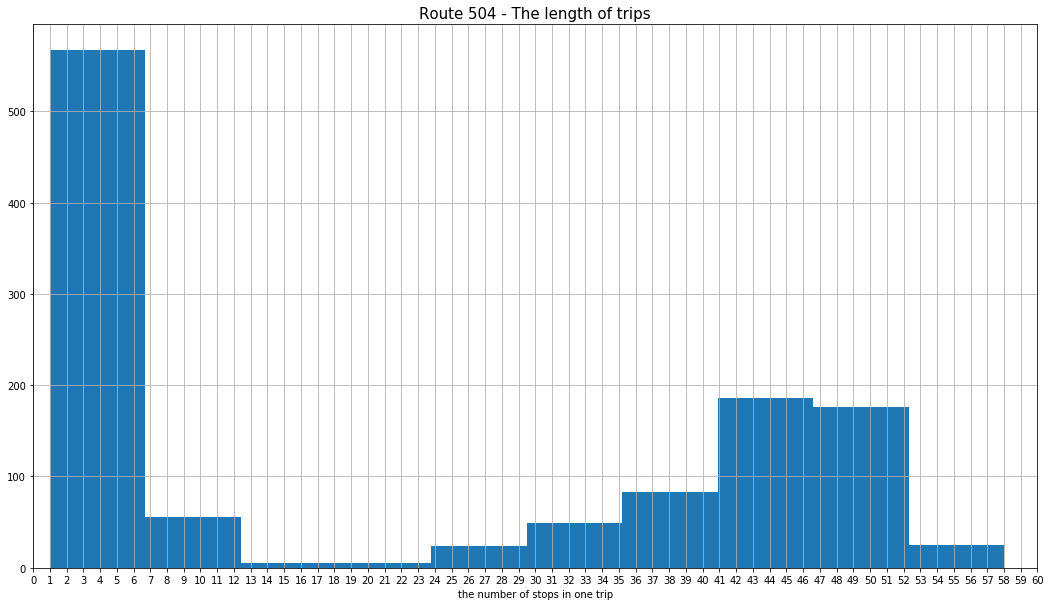

In [132]:
trips_504 = pandasql.read_sql(sql_find_tripIDs3_504_before, con)
trips_504.hist(figsize=(18,10))
plt.xlabel('the number of stops in one trip')
plt.title('Route 504 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 60])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

#### After removing non-service stops


In [26]:
sql_insert = '''
DROP TABLE IF EXISTS crosic.cis_504_10042017_tripids_after;

SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
INTO crosic.cis_504_10042017_tripids_after
FROM crosic.match_stop_504
ORDER BY vehicle, arrival_time;
'''
with con:
    with con.cursor() as cur:
        cur.execute(sql_delete)
        cur.execute(sql_insert)

In [125]:
sql_find_tripIDs3_504_after = '''
DROP SEQUENCE IF EXISTS tripid_seq;
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_504_10042017_tripids_after
ORDER BY vehicle, arrival_time
)
SELECT count(*) AS cnt
FROM trips
GROUP BY trip_id; 

'''

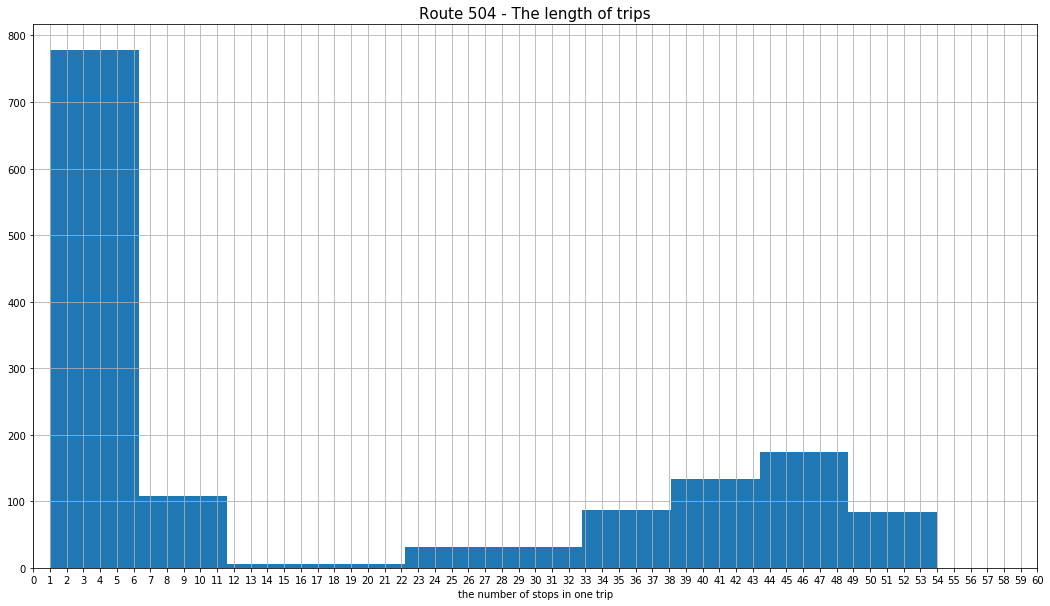

In [133]:
trips_504 = pandasql.read_sql(sql_find_tripIDs3_504_after, con)
trips_504.hist(figsize=(18,10))
plt.xlabel('the number of stops in one trip')
plt.title('Route 504 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 60])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

#### Compare before and after for route 504

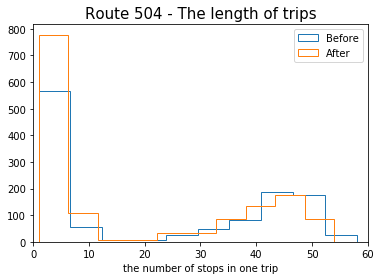

In [135]:
trips_504_before = (pandasql.read_sql(sql_find_tripIDs3_504_before, con)).values
trips_504_after = (pandasql.read_sql(sql_find_tripIDs3_504_after, con)).values
plt.hist(trips_504_before, label = 'Before', histtype= 'step', stacked = False)
plt.hist(trips_504_after, label='After', histtype = 'step', stacked = False)
plt.legend(loc='upper right')

plt.xlabel('the number of stops in one trip')
plt.title('Route 504 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 60])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

The overall trend has generally stayed the same: there are far more short trips than long trips. After removing the non-service stops from processing, there are now more shorter trips than longer trips. 

### Route 514

#### Before removing non-service stops

In [122]:
sql_delete = '''
DROP TABLE IF EXISTS crosic.cis_514_10042017_tripids;
'''

sql_insert = '''
SELECT * INTO crosic.cis_514_10042017_tripids
FROM
(SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM dzou2.match_stop_514
ORDER BY vehicle, arrival_time) AS T;
'''
#with con:
 #   with con.cursor() as cur:
  #      cur.execute(sql_delete)
  #      cur.execute(sql_insert)

sql_find_tripIDs3_514_before = '''
DROP SEQUENCE IF EXISTS tripid_seq;
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_514_10042017_tripids
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM trips
GROUP BY trip_id;
'''


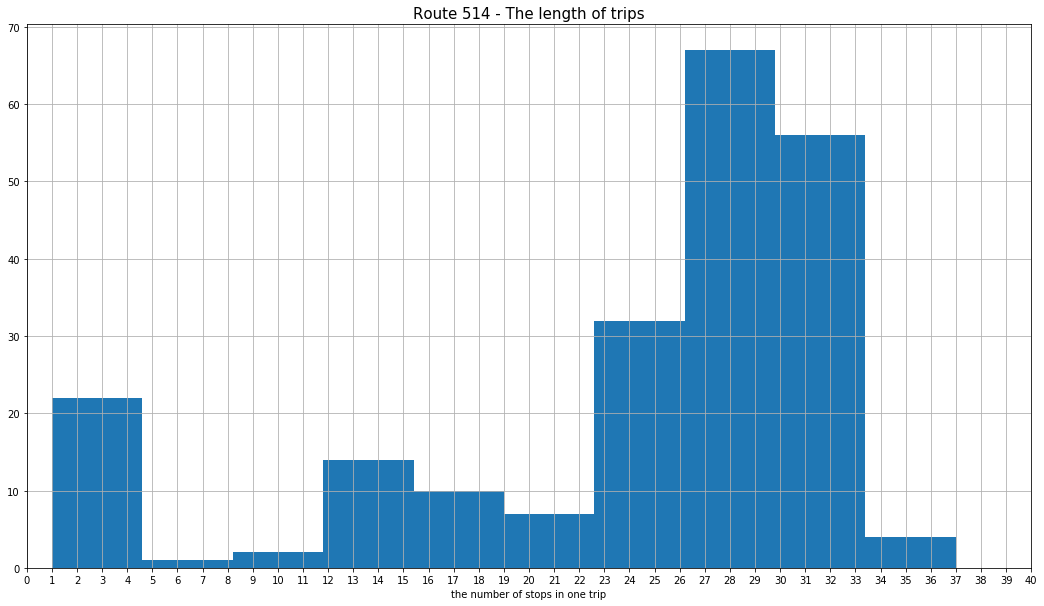

In [127]:
trips_514 = pandasql.read_sql(sql_find_tripIDs3_514_before, con)
trips_514.hist(figsize=(18,10))
plt.xlabel('the number of stops in one trip')
plt.title('Route 514 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 40])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

#### After removing non-service stops

In [54]:
sql_insert = '''
DROP TABLE IF EXISTS crosic.cis_514_10042017_tripids_after;

SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_group,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
INTO crosic.cis_514_10042017_tripids_after
FROM crosic.match_stop_514
ORDER BY vehicle, arrival_time;
'''
with con:
    with con.cursor() as cur:
        cur.execute(sql_delete)
        cur.execute(sql_insert)

In [118]:
sql_find_tripIDs3_514_after = '''
DROP SEQUENCE IF EXISTS tripid_seq; 
CREATE TEMPORARY SEQUENCE tripid_seq;
SELECT setval('tripid_seq', 1);

WITH trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('tripid_seq')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('tripid_seq')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('tripid_seq')
END) AS trip_id,
arrival_time, departure_time, cis_group, direction_id, vehicle, stop_id
FROM crosic.cis_514_10042017_tripids_after
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM trips
GROUP BY trip_id;
'''

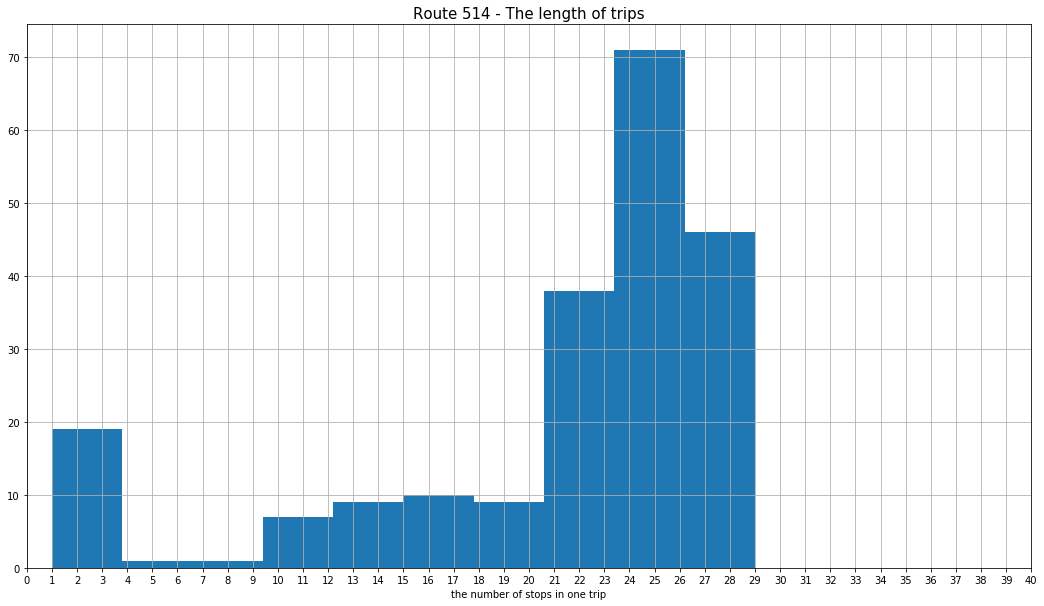

In [126]:
trips_514 = pandasql.read_sql(sql_find_tripIDs3_514_after, con)
trips_514.hist(figsize=(18,10))
plt.xlabel('the number of stops in one trip')
plt.title('Route 514 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 40])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

#### Compare before and after for route 514

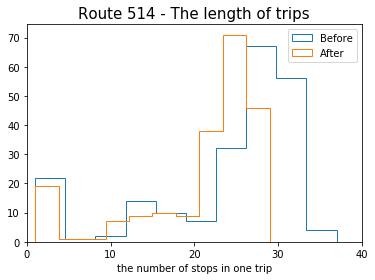

In [125]:
trips_514_before = (pandasql.read_sql(sql_find_tripIDs3_514_before, con)).values
trips_514_after = (pandasql.read_sql(sql_find_tripIDs3_514_after, con)).values
plt.hist(trips_514_before, label = 'Before', histtype= 'step')
plt.hist(trips_514_after, label='After', histtype = 'step')
plt.legend(loc='upper right')

plt.xlabel('the number of stops in one trip')
plt.title('Route 514 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 40])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

There is a difference in the length of some of the trips, however the general trend remains the same. 

### Compare GTFS trips to trips created with CIS data

The length that trips should be and the amount of trips at this length in a day according to the GTFS data. 

In [132]:
gtfs_len_sql = '''
WITH stops514 AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_514_stop_angle s1, dzou2.dd_514_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
), 

stops504 AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_504_stop_angle s1, dzou2.dd_504_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
), 

step_1 AS(SELECT route_short_name, trip_id, count(1) as length
FROM gtfs_raph.stop_times_20171004_504_514
WHERE (stop_id NOT IN (SELECT stop_id FROM stops504) AND stop_id NOT IN (SELECT stop_id FROM stops514))
OR stop_id IN (13050, 13209, 14186, 6113, 15439, 15356, 13268)
GROUP BY route_short_name, trip_id
)


SELECT route_short_name, length, count(1)
FROM step_1
GROUP BY route_short_name, length
ORDER BY route_short_name, length DESC; 
'''

gtfs_len = pandasql.read_sql(gtfs_len_sql, con)
gtfs_len 

,route_short_name,length,count
0,504,55,276
1,504,49,271
2,504,48,4
3,504,44,1
4,504,41,2
5,504,12,13
6,504,10,22
7,504,9,20
8,504,8,16
9,514,32,93


Create histograms to show the "ideal" distribution of stop lengths, according to the GTFS stop time data. 

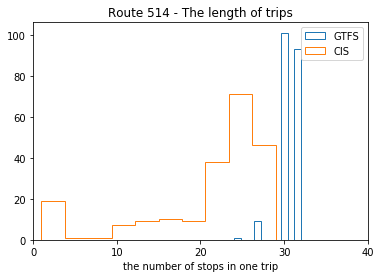

In [121]:
gtfs_len_514_sql = '''
WITH stops514 AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_514_stop_angle s1, dzou2.dd_514_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
), 

stops504 AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_504_stop_angle s1, dzou2.dd_504_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
), 

step_1 AS(SELECT route_short_name, trip_id, count(1) as length
FROM gtfs_raph.stop_times_20171004_504_514
WHERE (stop_id NOT IN (SELECT stop_id FROM stops504) AND stop_id NOT IN (SELECT stop_id FROM stops514))
	OR stop_id IN (13050, 13209, 14186, 6113, 15439, 15356, 13268)
GROUP BY route_short_name, trip_id
)


SELECT length
FROM step_1
WHERE route_short_name = '514'
-- GROUP BY route_short_name, length
-- ORDER BY route_short_name, length DESC; 
'''

trips_514_gtfs = pandasql.read_sql(gtfs_len_514_sql, con).values
trips_514_after = pandasql.read_sql(sql_find_tripIDs3_514_after, con).values
plt.hist(trips_514_gtfs, label = 'GTFS', histtype= 'step')
plt.hist(trips_514_after, label='CIS', histtype = 'step')
plt.legend(loc='upper right')

plt.xlabel('the number of stops in one trip')
plt.title('Route 514 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 40])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

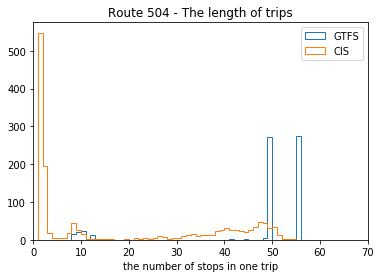

In [139]:
gtfs_len_504_sql = '''
WITH stops514 AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_514_stop_angle s1, dzou2.dd_514_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
), 

stops504 AS (
SELECT DISTINCT(s1.stop_id) stop_id
FROM dzou2.dd_504_stop_angle s1, dzou2.dd_504_stop_angle s2
WHERE s1.stop_id = s2.stop_id AND s1.direction_id <> s2.direction_id
), 

step_1 AS(SELECT route_short_name, trip_id, count(1) as length
FROM gtfs_raph.stop_times_20171004_504_514
WHERE (stop_id NOT IN (SELECT stop_id FROM stops504) AND stop_id NOT IN (SELECT stop_id FROM stops514))
OR stop_id IN (13050, 13209, 14186, 6113, 15439, 15356, 13268)
GROUP BY route_short_name, trip_id
)


SELECT length
FROM step_1 
WHERE route_short_name = '504'
'''

trips_504_gtfs = pandasql.read_sql(gtfs_len_504_sql, con).values
trips_504_after = pandasql.read_sql(sql_find_tripIDs3_504_after, con).values


bins = np.linspace(1, 100, 100)
plt.hist(trips_504_gtfs, label = 'GTFS', histtype= 'step', stacked = False, bins=bins)
plt.hist(trips_504_after, label='CIS', histtype = 'step', stacked = False, bins=bins)
plt.legend(loc='upper right')

plt.xlabel('the number of stops in one trip')
plt.title('Route 504 - The length of trips')
ax = plt.gca()
ax.set_xlim([0, 70])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

# Systematically identifying CIS points that cause trips to end early

Some CIS GPS points are not identified to be in the correct location due to issues with the GPS, causing trips to end early. In order to remove these points from processing, we must find a way to identify them. 

## Exploring speed and distance between CIS data points 

First graph distance and speed between points to gain an understanding as to what is a "normal" speed and distance between the CIS points. 

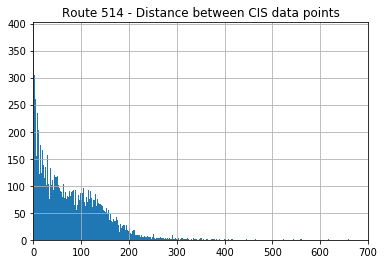

In [59]:
# partition through CIS data points 
# get distances between points


# the date_time comparions (date_time1, date_time2) thing doesnt make a difference
distance_cis_sql = '''
WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist, date_time AS date_time1, lag(date_time, 1) OVER (PARTITION BY vehicle ORDER BY date_time) AS date_time2
FROM crosic.dd_cis_514_angle   
)

SELECT dist, date_time1, date_time2 from all_dist 
WHERE date_time1 <> date_time2 and dist > 0;
'''

bins = np.linspace(1, 700, 700)
distance_cis = pandasql.read_sql(distance_cis_sql, con)
distance_cis.hist(bins=bins)
plt.title('Route 514 - Distance between CIS data points')
ax = plt.gca()
ax.set_xlim([0, 700])
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

plt.show()


The maximum distance between two CIS points in 18274.641432 metres (about 182 kilometres)

In [17]:
sql_max_dist = '''
WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist, date_time AS date_time1, (lag(date_time, 1) OVER (PARTITION BY vehicle ORDER BY date_time)) AS date_time2
FROM crosic.dd_cis_514_angle   
)

SELECT MAX(dist) from all_dist 
WHERE dist > 0 and date_time1 <> date_time2;
'''
max_dist = pandasql.read_sql(sql_max_dist, con)
max_dist

,max
0,18274.641432


In [9]:
sql_count_g100_dist = '''
WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist
FROM crosic.dd_cis_514_angle)

SELECT COUNT(*) from all_dist 
WHERE dist > 100;
'''
count_dist_g100 = pandasql.read_sql(sql_count_g100_dist, con)
count_dist_g100

,count
0,6069


In [10]:
sql_count_l100_dist = '''
WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist
FROM crosic.dd_cis_514_angle)

SELECT COUNT(*) from all_dist 
WHERE dist <= 100;
'''
count_dist_l100 = pandasql.read_sql(sql_count_l100_dist, con)
count_dist_l100

,count
0,17120


Find the greatest time differences between CIS data points collected. The highest is over 5 hours. Times that are over 5 minutes (all times over 5 mins in our case are also over 2.5 hours) should be filtered out because the bus/streetcar was (most likely) not running for the entire time. The lowest time difference is 18 seconds. 

In [96]:
distance_cis_sql = '''
WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist, date_time AS date_time1, lag(date_time, 1) OVER (PARTITION BY vehicle ORDER BY date_time) AS date_time2
FROM crosic.dd_cis_514_angle   
)

SELECT dist, date_time1, date_time2, 
TO_TIMESTAMP(to_char(date_time1, 'HH24:MI:SS'), 'HH24:MI:SS') - TO_TIMESTAMP(to_char(date_time2, 'HH24:MI:SS'), 'HH24:MI:SS') AS time_diff
FROM all_dist 
WHERE date_time1 <> date_time2 
ORDER BY time_diff DESC
LIMIT 50;
'''

distance_cis = pandasql.read_sql(distance_cis_sql, con)
distance_cis


,dist,date_time1,date_time2,time_diff
0,134.352744,2017-10-04 15:00:00,2017-10-04 09:56:20,05:03:40
1,107.666780,2017-10-04 15:09:40,2017-10-04 10:53:00,04:16:40
2,168.856077,2017-10-04 14:25:20,2017-10-04 10:57:40,03:27:40
3,98.006578,2017-10-04 06:19:40,2017-10-04 03:29:40,02:50:00
4,53.864671,2017-10-04 16:09:20,2017-10-04 16:04:20,00:05:00
5,499.861670,2017-10-04 10:02:40,2017-10-04 09:57:40,00:05:00
6,659.532053,2017-10-04 17:29:00,2017-10-04 17:26:00,00:03:00
7,643.995461,2017-10-04 18:05:20,2017-10-04 18:02:20,00:03:00
8,0.000000,2017-10-04 07:15:00,2017-10-04 07:12:20,00:02:40
9,348.976301,2017-10-04 20:11:20,2017-10-04 20:08:40,00:02:40


Calculate the average speeds of the streetcars between each of the CIS point in kilometres/hour. 

In [95]:
explore_speed_cis_sql = '''
CREATE OR REPLACE FUNCTION to_seconds(t text)
  RETURNS integer AS
$BODY$ 
DECLARE 
    hs INTEGER;
    ms INTEGER;
    s INTEGER;
BEGIN
    SELECT (EXTRACT( HOUR FROM  t::time) * 60*60) INTO hs; 
    SELECT (EXTRACT (MINUTES FROM t::time) * 60) INTO ms;
    SELECT (EXTRACT (SECONDS from t::time)) INTO s;
    SELECT (hs + ms + s) INTO s;
    RETURN s;
END;
$BODY$
  LANGUAGE 'plpgsql';



WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist, date_time AS date_time1, lag(date_time, 1) OVER (PARTITION BY vehicle ORDER BY date_time) AS date_time2
FROM crosic.dd_cis_514_angle   
),

get_time_diff AS (
SELECT dist, date_time1, date_time2, 
TO_TIMESTAMP(to_char(date_time1, 'HH24:MI:SS'), 'HH24:MI:SS') - TO_TIMESTAMP(to_char(date_time2, 'HH24:MI:SS'), 'HH24:MI:SS')
AS time_diff
FROM all_dist
)

SELECT dist, date_time1, date_time2, time_diff, 
to_seconds(to_char(time_diff, 'HH24:MI:SS')) AS seconds, 
(to_seconds(to_char(time_diff, 'HH24:MI:SS'))/(60.0*60.0)) AS hours, 
(dist/1000) / (to_seconds(to_char(time_diff, 'HH24:MI:SS'))/(60.0*60.0)) AS km_speed_per_hour
FROM get_time_diff
WHERE date_time1 <> date_time2
ORDER BY time_diff DESC
LIMIT 20;
'''

explore_speed_cis = pandasql.read_sql(explore_speed_cis_sql, con)
explore_speed_cis


,dist,date_time1,date_time2,time_diff,seconds,hours,km_speed_per_hour
0,134.352744,2017-10-04 15:00:00,2017-10-04 09:56:20,05:03:40,18220,5.061111,0.026546
1,107.666780,2017-10-04 15:09:40,2017-10-04 10:53:00,04:16:40,15400,4.277778,0.025169
2,168.856077,2017-10-04 14:25:20,2017-10-04 10:57:40,03:27:40,12460,3.461111,0.048787
3,98.006578,2017-10-04 06:19:40,2017-10-04 03:29:40,02:50:00,10200,2.833333,0.034591
4,53.864671,2017-10-04 16:09:20,2017-10-04 16:04:20,00:05:00,300,0.083333,0.646376
5,499.861670,2017-10-04 10:02:40,2017-10-04 09:57:40,00:05:00,300,0.083333,5.998340
6,659.532053,2017-10-04 17:29:00,2017-10-04 17:26:00,00:03:00,180,0.050000,13.190641
7,643.995461,2017-10-04 18:05:20,2017-10-04 18:02:20,00:03:00,180,0.050000,12.879909
8,348.976301,2017-10-04 20:11:20,2017-10-04 20:08:40,00:02:40,160,0.044444,7.851967
9,0.000000,2017-10-04 15:25:00,2017-10-04 15:22:20,00:02:40,160,0.044444,0.000000


Now create a histogram of the speeds.

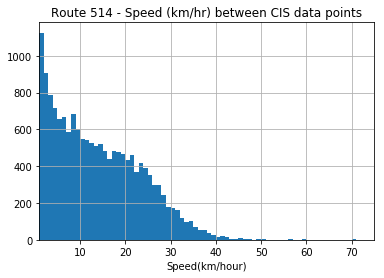

In [104]:
speed_cis_sql = '''
CREATE OR REPLACE FUNCTION to_seconds(t text)
  RETURNS integer AS
$BODY$ 
DECLARE 
    hs INTEGER;
    ms INTEGER;
    s INTEGER;
BEGIN
    SELECT (EXTRACT( HOUR FROM  t::time) * 60*60) INTO hs; 
    SELECT (EXTRACT (MINUTES FROM t::time) * 60) INTO ms;
    SELECT (EXTRACT (SECONDS from t::time)) INTO s;
    SELECT (hs + ms + s) INTO s;
    RETURN s;
END;
$BODY$
  LANGUAGE 'plpgsql';



WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist, date_time AS date_time1, lag(date_time, 1) OVER (PARTITION BY vehicle ORDER BY date_time) AS date_time2
FROM crosic.dd_cis_514_angle   
),

get_time_diff AS (
SELECT dist, date_time1, date_time2, 
TO_TIMESTAMP(to_char(date_time1, 'HH24:MI:SS'), 'HH24:MI:SS') - TO_TIMESTAMP(to_char(date_time2, 'HH24:MI:SS'), 'HH24:MI:SS')
AS time_diff
FROM all_dist
WHERE dist > 0
)

SELECT date_time1, date_time2, time_diff, 
(dist/1000) / (to_seconds(to_char(time_diff, 'HH24:MI:SS'))/(60.0*60.0)) AS km_speed_per_hour
FROM get_time_diff;
'''

bins = np.linspace(1, 75, 75)
distance_cis = pandasql.read_sql(speed_cis_sql, con)
distance_cis.hist(bins=bins)
plt.title('Route 514 - Speed (km/hr) between CIS data points')
plt.xlabel("Speed(km/hour)")
ax = plt.gca()
ax.set_xlim([1, 75])
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))


plt.show()

The maximum speed between two CIS points is too large to be accurate, so some filtering must be done to remove points like these. 

In [105]:
sql_max_speed_514 = '''
CREATE OR REPLACE FUNCTION to_seconds(t text)
  RETURNS integer AS
$BODY$ 
DECLARE 
    hs INTEGER;
    ms INTEGER;
    s INTEGER;
BEGIN
    SELECT (EXTRACT( HOUR FROM  t::time) * 60*60) INTO hs; 
    SELECT (EXTRACT (MINUTES FROM t::time) * 60) INTO ms;
    SELECT (EXTRACT (SECONDS from t::time)) INTO s;
    SELECT (hs + ms + s) INTO s;
    RETURN s;
END;
$BODY$
  LANGUAGE 'plpgsql';



WITH all_dist AS
(SELECT 
ST_DISTANCE(ST_TRANSFORM(position, 32190), ST_Transform((lag(position, 1) OVER (PARTITION BY vehicle ORDER BY date_time)), 32190))
AS dist, date_time AS date_time1, lag(date_time, 1) OVER (PARTITION BY vehicle ORDER BY date_time) AS date_time2
FROM crosic.dd_cis_514_angle   
),

get_time_diff AS (
SELECT dist, date_time1, date_time2, 
TO_TIMESTAMP(to_char(date_time1, 'HH24:MI:SS'), 'HH24:MI:SS') - TO_TIMESTAMP(to_char(date_time2, 'HH24:MI:SS'), 'HH24:MI:SS')
AS time_diff
FROM all_dist
WHERE dist > 0
)

SELECT MAX((dist/1000) / (to_seconds(to_char(time_diff, 'HH24:MI:SS'))/(60.0*60.0))) 
FROM get_time_diff;
'''
max_speed_514 = pandasql.read_sql(sql_max_speed_514, con)
max_speed_514

,max
0,3289.435458


In [ ]:
con.close()